Import Libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Load Dataset

In [15]:
dataset = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")
dataset.shape
#dataset.columns

(144, 2)

Plot Dataset chart (Months vs Passengers)

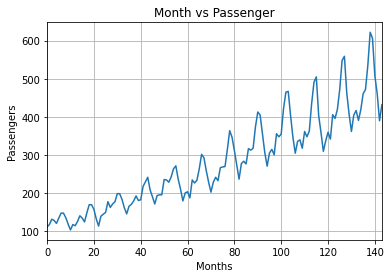

In [3]:
plt.title('Month vs Passenger')
plt.ylabel('Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(dataset['Passengers'])

Preprocess data

In [4]:
dataset.columns
all_data = dataset['Passengers'].values.astype(float)
test_data_size = 12 #12 months in a year

#Split dataset into Training vs Testing Data
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]
print(len(train_data))
print(len(test_data))

132
12


In [5]:
#Normalize data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

#convert dataset to Tensor
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_window = 12

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]), tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]), tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]), tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]), tensor([-0.9077]))]

**Develop LSTM MODEL**

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


Training the Model

In [7]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00065688
epoch:  26 loss: 0.01114427
epoch:  51 loss: 0.00177661
epoch:  76 loss: 0.00170150
epoch: 101 loss: 0.00009327
epoch: 126 loss: 0.00234612
epoch: 149 loss: 0.0000015476


Predicting the Model for 12 Months

In [8]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
        
test_inputs[fut_pred:]


[0.6342213749885559,
 1.1777894496917725,
 1.409500002861023,
 1.5585626363754272,
 1.6607636213302612,
 1.7294951677322388,
 1.826315999031067,
 1.983411192893982,
 2.164748191833496,
 2.3582780361175537,
 2.614321708679199,
 2.9519569873809814]

In [9]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[ 475.78536281]
 [ 599.4470998 ]
 [ 652.16125065]
 [ 686.07299978]
 [ 709.32372385]
 [ 724.96015066]
 [ 746.98688978]
 [ 782.72604638]
 [ 823.98021364]
 [ 868.00825322]
 [ 926.25818872]
 [1003.07021463]]


In [10]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


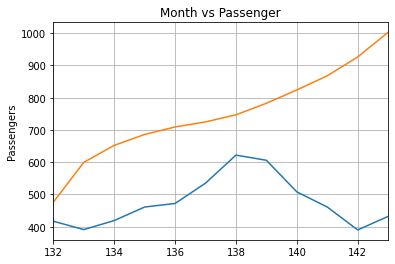

In [13]:
plt.title('Month vs Passenger')
plt.ylabel('Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(dataset['Passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()

Learning Resource
1. https://pytorch.org/tutorials/beginner/introyt/introyt1_tutorial.html
2. https://www.freecodecamp.org/learn/machine-learning-with-python/tensorflow/core-learning-algorithms-working-with-data
3. https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/
4. https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7